In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from keras.layers import Dense, SimpleRNN, RNN, LSTM,Dropout,Bidirectional,Attention,Embedding
from keras.optimizers import Adam,SGD,RMSprop,schedules
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [3]:
# Config for text vectorizer
# max_features = 5000  # Maximum vocab size.
max_features = 200  # Maximum vocab size. # vocabsize found as 192 see below
max_len = 8  # Sequence length to pad the outputs to.
embedding_dims = 2

In [4]:
# read the text part of the data set
x_train=[]
f = open("hackt.txt", "r")
for l in f:
  x_train.append([l.replace("\n","")])
f.close()

In [5]:
# read the prices of the data set
prices=[]
f = open("hackp.txt", "r")
for l in f:
  prices.append([float(l.replace("\n",""))])
f.close()

In [6]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
y_train = scaler.fit_transform(prices)

# our trainings values
x_train

[['CPU10c RAM10 S18 GPU1 15 UHD NonXTouch US'],
 ['CPU10c RAM10 S2 GPU25 15 FHD NonXTouch CN'],
 ['CPU10c RAM7 S23 GPU14 15 FHD NonXTouch CN'],
 ['CPU10d RAM14 S45 GPU13 15 QHDP NonXTouch DE'],
 ['CPU10c RAM7 S30 GPU1 15 UHD Touch US'],
 ['CPU10d RAM7 S11 GPU26 17 FHD NonXTouch DE'],
 ['CPU10c RAM14 S56 GPU1 15 UHD NonXTouch CN'],
 ['CPU10c RAM10 S18 GPU1 13 UHD Touch CN'],
 ['CPU11c RAM7 S11 GPU6 15 UHD NonXTouch US'],
 ['CPU18c RAM7 S23 GPU16 15 FHD Touch US'],
 ['CPU10c RAM10 S18 GPU16 15 UHD Touch JP'],
 ['CPU10c RAM10 S33 GPU27 17 FHD NonXTouch CN'],
 ['CPU10b RAM10 S45 GPU1 15 FHD NonXTouch IN'],
 ['CPU10c RAM14 S45 GPU21 17 FHD NonXTouch BR'],
 ['CPU11c RAM10 S18 GPU25 17 FHD NonXTouch CN'],
 ['CPU8b RAM7 S11 GPU14 15 FHD NonXTouch UK'],
 ['CPU10b RAM12 S11 GPU18 15 FHD NonXTouch US'],
 ['CPU12b RAM7 S23 GPU1 23 FHD Touch AU'],
 ['CPU10c RAM10 S18 GPU21 15 FHD NonXTouch UK'],
 ['CPU10c RAM10 S18 GPU25 15 FHD Touch DE'],
 ['CPU10c RAM10 S33 GPU18 15 FHD NonXTouch DE'],
 ['CPU12f 

In [7]:
#Convert the x_train and y_train to numpy arrays, Keras needs it for model.fit 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2477, 1)

In [8]:
# Create the text vectorization layerlayer.
vectorize_layer = TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

# dapadt builds the vocab for later vectorization
vectorize_layer.adapt(x_train)

In [9]:
# print the length of the vocab and the vocab, just to see it
print(len(vectorize_layer.get_vocabulary()))
vectorize_layer.get_vocabulary()

146


['',
 '[UNK]',
 'nonxtouch',
 'fhd',
 '15',
 'gpu1',
 'cpu10c',
 'ram7',
 'ram10',
 'us',
 'touch',
 's23',
 'cn',
 'cpu10b',
 '17',
 'de',
 's11',
 's18',
 'ram4',
 'uhd',
 '13',
 'ram14',
 '14',
 'hdp',
 'gpu14',
 's33',
 's30',
 'br',
 'cpu11c',
 'uk',
 'gpu18',
 'gpu6',
 'in',
 'cpu8b',
 's6',
 'qhdp',
 'fr',
 's45',
 'cpu10d',
 'gpu16',
 'jp',
 's17',
 'gpu4',
 'cpu18c',
 's36',
 'gpu21',
 'gpu26',
 'gpu25',
 'cpu8a',
 'au',
 '12',
 'ram9',
 'fhdp',
 'gpu27',
 'gpu15',
 'hd',
 'cpu11b',
 's26',
 'gpu29',
 'qhd',
 'gpu5',
 'cpu5c',
 'gpu13',
 '23',
 's25',
 'cpu12b',
 'cpu20',
 '27',
 's2',
 's10',
 'ram2',
 'cpu5b',
 'cpu18a',
 'gpu3',
 's50',
 's53',
 'gpu2',
 'cpu12a',
 's56',
 's3',
 '10',
 's37',
 'ram6',
 '21',
 'cpu17',
 'ram12',
 'cpu14',
 's43',
 'cpu15',
 'gpu12',
 'cpu9',
 's14',
 'gpu7',
 'cpu12f',
 '18',
 's71',
 's58',
 's4',
 's38',
 'ram11',
 '16',
 '11',
 's57',
 's35',
 'gpu22',
 'cpu3c',
 'cpu12e',
 's27',
 's22',
 'ram15',
 's7',
 's5',
 's21',
 'gpu11',
 'gpu10

In [10]:
# start to build the model
model = tf.keras.models.Sequential()
# define the input shape
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
#add the text vectorizer
model.add(vectorize_layer)

In [ ]:
# let's see what the vectorizer will do 
model.predict(x_train)

In [ ]:
# that's how the model looks like at the moment
model.summary()

In [11]:
# add the embdeing layer the intergers will be transformed to in this case 128 element vector
model.add(Embedding(max_features + 1, 128))

In [ ]:
# that's how the model looks like at the moment
# the embeding is trainable, so model.predict does not make sense here
model.summary()

In [12]:
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(25,activation="relu"))
model.add(Dense(1))

In [ ]:
# that's how the model looks like at the moment
model.summary()

In [13]:
#Compile the model
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.95)
opt = SGD(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss='mean_squared_error')

In [14]:
#Train the model
model_info=model.fit(x_train, y_train, batch_size=1, epochs=100,verbose=1, shuffle=False, validation_split=0.1)
# train for anomaly dection
# model_info=model.fit(x_train, y_train, batch_size=4, epochs=500,verbose=1, shuffle=True)

Epoch 1/100
2229/2229 [==============================] - 17s 8ms/step - loss: 0.0197 - val_loss: 0.0142
Epoch 2/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0173 - val_loss: 0.0130
Epoch 3/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0145 - val_loss: 0.0098
Epoch 4/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 5/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 6/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0093 - val_loss: 0.0055
Epoch 7/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0086 - val_loss: 0.0047
Epoch 8/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0081 - val_loss: 0.0043
Epoch 9/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 10/100
2229/2229 [==============================] - 17s 7m

2229/2229 [==============================] - 17s 7ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 80/100
2229/2229 [==============================] - 16s 7ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 81/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 82/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 83/100
2229/2229 [==============================] - 16s 7ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 84/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 85/100
2229/2229 [==============================] - 16s 7ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 86/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 87/100
2229/2229 [==============================] - 17s 7ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 88/100
2229/2229 [==============================] - 17s 7ms/st

In [ ]:
pred_price = model.predict([['CPU5b RAM4 S23 GPU1 13 FHD Non-Touch IN']])
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

In [15]:
pred_prices=model.predict(x_train)
pred_prices = scaler.inverse_transform(pred_prices)
#pred_prices

In [16]:
price_err=100*((pred_prices-prices)/prices)

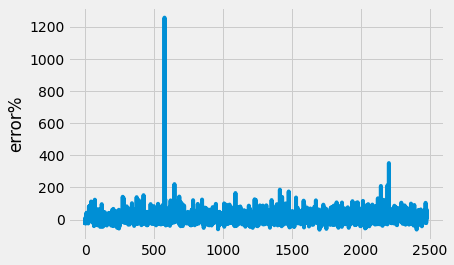

In [17]:

plt.plot(price_err[:,0])
plt.ylabel('error%')
plt.show()

In [18]:
c=0
for i in range(len(price_err[:,0])):
    if(price_err[i][0]>1):
        c=c+1
print(c)

1502


In [19]:
for i in range(len(price_err[:,0])):
    if(price_err[i][0]>1000):
        print(x_train[i][0])
        print(prices[i][0])
        print(pred_prices[i][0])

CPU10c RAM10 S33 GPU1 14 FHD NonXTouch DE
116.82
1585.119


In [20]:
for i in range(1):
    percent=(i+1)
    t_fnam="hack_txt_ref"+str(percent)+".txt"
    p_fnam="hack_price_ref"+str(percent)+".txt"
    p=open(p_fnam,"w")
    t=open(t_fnam,"w")
    for l in range(len(price_err[:,0])):
        if(price_err[l][0]<percent):
            t.write(x_train[l][0])
            t.write("\n")
            p.write(str(prices[l][0]))
            p.write("\n")
t.close()
p.close()


In [ ]:
price_err[0,0]


In [ ]:
model.save("hack_model/lstm_01")